In [1]:
import setGPU
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import pandas
import time
import math
import pickle

from functools import total_ordering

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

setGPU: Setting GPU to: 0


In [2]:
from JupyterLoader import NotebookFinder
import sys
sys.meta_path.append(NotebookFinder())

In [3]:
#from dataloaders.unified_Berlino_dataloader import get_loaders
from dataloaders.synth_Berlino_dataloader import get_loaders
batch_size = 8
num_workers = 4
dataloaders, display, vocab = get_loaders(folder='/home/frati/',
                               split = (0.3,0.5), 
                               dataset='full',
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=num_workers,
                               seed=5)

importing Jupyter notebook from /home/frati/new_Grasping/code/dataloaders/synth_Berlino_dataloader.ipynb


In [4]:
def get_batch(phase):
    return next(iter(dataloaders[phase]))

In [5]:
#from models.colorNet import ColorNet
#from models.viewPooler import ViewPooler
#from models.partialVGG import get_partialVGG

In [6]:
from utilities import AverageMeter, accuracy, get_trainable_parameters, varify

importing Jupyter notebook from utilities.ipynb


In [7]:
from types import SimpleNamespace
args = {'model_path':'./models/',
 'crop_size': 224,
 'vocab_path':'./data/vocab.pkl',
 'image_dir':'./data/resized2014',
 'caption_path':'./data/annotations/captions_train2014.json',
 'log_step':10,
 'save_step':1000,
 'embed_size':256,
 'hidden_size':512,
 'num_layers':1,
 'num_epochs':5,
 'batch_size':128,
 'num_workers':2,
 'learning_rate':0.001}
args = SimpleNamespace(**args)

In [8]:
class ViewPooler(nn.Module):
    def __init__(self, embed_size, views):
        super(ViewPooler, self).__init__()
        self.features_extractor = models.vgg16_bn(pretrained=True).features
        for param in self.features_extractor.parameters(): # freeze VGG
            param.requires_grad = False
        self.view_pooling = nn.MaxPool2d(kernel_size=(views,1))
        in_features = 512*7*7
        self.relu = nn.ReLU()
        self.fc_1 = nn.Linear(in_features, embed_size)
        #self.fc_2 = nn.Linear(4096,embed_size)
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(in_features, momentum=0.01)

    def forward(self, views):
        views_features = [self.features_extractor(view) for view in views]
        
        ims,filters,h,w = views_features[0].shape
        
        flat_views = [view.view(ims,-1) for view in views_features]
        stacked_views = torch.stack(flat_views,dim=1)
        pooled_views = self.view_pooling(stacked_views).squeeze()
        
        features = Variable(pooled_views.data) # can set volatile to input images to avoid wasted gradients
        features = self.bn(features)
        features = self.fc_1(features)
        
        return features


In [18]:
class ColorNet(nn.Module):
    def __init__(self, pretrained = None):
        super(ColorNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 1)
        self.conv2 = nn.Conv2d(10, 3, 1)
        self.conv2_bn = nn.BatchNorm2d(3,affine=True)
        if pretrained is None:
            self.init_weights()
        else:
            state = torch.load(pretrained, map_location=lambda storage, loc: storage)
            self.load_state_dict(state['state_dict'])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
    
    def init_weights(self):
        """Initialize the weights."""
        self.conv1.weight.data.normal_(1/3, 0.01)
        self.conv1.bias.data.fill_(0)
        self.conv2.weight.data.normal_(1/3, 0.01)
        self.conv2.bias.data.fill_(0)
        
class colorPooler(nn.Module):
    def __init__(self, embed_size, views):
        super(colorPooler, self).__init__()
        self.features_extractor = nn.Sequential(ColorNet(pretrained='/home/frati/new_Grasping/code/models/pseudo_colorer.pth.tar'), models.vgg16_bn(pretrained=True).features)
        for param in self.features_extractor[1].parameters(): # freeze VGG
            param.requires_grad = False
        self.view_pooling = nn.MaxPool2d(kernel_size=(views,1))
        in_features = 512*7*7
        self.relu = nn.ReLU()
        self.fc_1 = nn.Linear(in_features, embed_size)
        #self.fc_2 = nn.Linear(4096,embed_size)
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(in_features, momentum=0.01)

    def forward(self, views):
        views_features = [self.features_extractor(view) for view in views]
        
        ims,filters,h,w = views_features[0].shape
        
        flat_views = [view.view(ims,-1) for view in views_features]
        stacked_views = torch.stack(flat_views,dim=1)
        pooled_views = self.view_pooling(stacked_views).squeeze()
        
        features = Variable(pooled_views.data) # can set volatile to input images to avoid wasted gradients
        features = self.bn(features)
        features = self.fc_1(features)
        
        return features

In [19]:
encoder = colorPooler(embed_size = args.embed_size, views=4)

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        """Initialize weights."""
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
        
    def forward(self, features, tags, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(tags)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Samples captions for given image features (Greedy search)."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(20):                                      # maximum sampling length
            hiddens, states = self.lstm(inputs, states)          # (batch_size, 1, hidden_size), 
            outputs = self.linear(hiddens.squeeze(1))            # (batch_size, vocab_size)
            predicted = outputs.max(1)[1]
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)                         # (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                  # (batch_size, 20)
        return sampled_ids.squeeze()
    
    def my_sample(self, features, states=None):
        """Samples captions for given image features (Greedy search)."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        stop = False
        while not stop:                                      # maximum sampling length
            hiddens, states = self.lstm(inputs, states)          # (batch_size, 1, hidden_size), 
            outputs = self.linear(hiddens.squeeze(1))            # (batch_size, vocab_size)
            predicted = outputs.max(1)[1]
            sampled_ids.append(predicted)
            stop = vocab.is_stop(predicted.cpu().data.numpy())
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)                         # (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                  # (batch_size, 20)
        return sampled_ids.squeeze()
    

In [21]:
decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers)

In [22]:
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

In [23]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + get_trainable_parameters(encoder)
optimizer = torch.optim.Adam(params, lr=args.learning_rate)

Trainable parameters:	     6473019
Frozen parameters:	    14723136


In [24]:
data_loader = dataloaders['train']

total_step = len(data_loader)
best_valid = 0
best_enc = encoder.state_dict()
best_dec = decoder.state_dict()

for epoch in range(args.num_epochs):
    encoder.train()
    decoder.train()
    for i, (images, captions, lengths, objs) in enumerate(dataloaders['train']):

        # Set mini-batch dataset
        images = varify(images, volatile=True)
        ###
        images = [view[:,1,...].unsqueeze(1) for view in images]
        ###
        captions = varify(captions)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, Backward and Optimize
        decoder.zero_grad()
        encoder.zero_grad()
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Print log info
        if i % args.log_step == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f'
                  %(epoch, args.num_epochs, i, total_step, 
                    loss.data[0], np.exp(loss.data[0])))
    
    encoder.eval()
    decoder.eval()
    correct = 0
    num_tags = 0
    for i, (images, captions, lengths, objs) in enumerate(dataloaders['valid']):
        # Set mini-batch dataset
        images = varify(images, volatile=True)
        ###
        images = [view[:,1,...].unsqueeze(1) for view in images]
        ###
        captions = varify(captions,volatile=True)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        _,preds = torch.max(outputs,1)
        correct += int(torch.sum(preds == targets))
        num_tags += float(sum(lengths))
        
    valid_acc = correct/num_tags
    if valid_acc > best_valid:
        best_valid = valid_acc
        best_enc = encoder.state_dict()
        best_dec = decoder.state_dict()
    print('Validation Accuracy {:.3f}'.format(valid_acc))
print("Best validation acc: {:.2f}".format(valid_acc))
encoder.load_state_dict(best_enc)
decoder.load_state_dict(best_dec)

Epoch [0/5], Step [0/377], Loss: 8.2953, Perplexity: 4005.1631
Epoch [0/5], Step [10/377], Loss: 5.8576, Perplexity: 349.8797
Epoch [0/5], Step [20/377], Loss: 3.5936, Perplexity: 36.3643
Epoch [0/5], Step [30/377], Loss: 3.4270, Perplexity: 30.7829
Epoch [0/5], Step [40/377], Loss: 3.0013, Perplexity: 20.1125
Epoch [0/5], Step [50/377], Loss: 3.4989, Perplexity: 33.0779
Epoch [0/5], Step [60/377], Loss: 2.7248, Perplexity: 15.2532
Epoch [0/5], Step [70/377], Loss: 2.9636, Perplexity: 19.3676
Epoch [0/5], Step [80/377], Loss: 2.1235, Perplexity: 8.3602
Epoch [0/5], Step [90/377], Loss: 2.1456, Perplexity: 8.5469
Epoch [0/5], Step [100/377], Loss: 2.5355, Perplexity: 12.6222
Epoch [0/5], Step [110/377], Loss: 2.7783, Perplexity: 16.0911
Epoch [0/5], Step [120/377], Loss: 2.2242, Perplexity: 9.2464
Epoch [0/5], Step [130/377], Loss: 2.3269, Perplexity: 10.2457
Epoch [0/5], Step [140/377], Loss: 2.2843, Perplexity: 9.8187
Epoch [0/5], Step [150/377], Loss: 1.8547, Perplexity: 6.3896
Epoch

Process Process-3:
Process Process-4:
Process Process-2:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/frati/miniconda3/envs/pytorch3.1/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/frati/miniconda3/envs/pytorch3.1/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/frati/miniconda3/envs/pytorch3.1/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/frati/miniconda3/envs/pytorch3.1/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/frati/miniconda3/envs/pytorch3.1/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/frati/miniconda3/envs/pytorch3.1/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._

RuntimeError: DataLoader worker (pid 137042) exited unexpectedly with exit code 1.

In [77]:
#torch.save(encoder.state_dict(),"my_encoder.pkl")
#torch.save(decoder.state_dict(),"my_decoder.pkl")

In [78]:
class Beam():
    
    def __init__(self, decoder, embed, translate, beam_size, vocabulary, penalty):
        self.decoder = decoder
        self.embed = embed
        self.translate = translate
        self.beam_size = beam_size
        self.vocab = vocab
        self.penalty = penalty
        self.finished_beams = []
        self.logsoftmax = torch.nn.LogSoftmax()
        self.beam_started = False
        self.states = None
        
    def start_beams(self,seed):
        self.finished_beams = []
        seed = seed.unsqueeze(0).unsqueeze(0) # beam deals with one view at a time
        outputs, state = self.decoder(seed, None)
        decoded = self.translate(outputs.squeeze(1))
        probs, preds = self.logsoftmax(decoded).topk(self.beam_size) # populate beam with the first characters
        self.beam = [Candidate(probs[0,i],[preds[0,i]],preds[0,i],state,self.penalty) for i in range((probs.shape)[1])]
    
    def sample_beams(self):
        safety = True
        safety_counter = 0
        safety_limit = 100
        while (len(self.finished_beams) < self.beam_size and safety):
            candidates_prob = []
            new_states = []
            for candidate in self.beam:
                pred, state = candidate
                # embed
                emb = self.embed(pred) # embedding is [100]
                emb = emb.view(1,1,-1) # turn embedding into batch,seq,values : 1,1,100
                # compute
                new_output, new_state = self.decoder(emb,state)
                new_states.append(new_state)
                # decode
                new_output.view(1,-1) # remove fake batch
                new_decoded = self.translate(new_output).view(1,-1)
                # score
                word_probs = self.logsoftmax(new_decoded)

                #word_probs += candidate.prob
                normalized_probs = candidate.normalize_probs(word_probs)

                candidates_prob.append(normalized_probs)

            flat_candidates = torch.cat(candidates_prob).view(-1)
            
            top_scores, top_words = flat_candidates.topk(self.beam_size)
            new_words = top_words % len(vocab)
            beams_id = top_words.cpu().data.numpy() // len(vocab)
            
            expanded_beam = []

            for beam_id, new_word, score in zip(beams_id, new_words, top_scores):
                new_candidate = self.beam[beam_id].update(score, new_word, new_states[beam_id])
                if vocab.is_stop(new_word.cpu().data.numpy()):
                    self.finished_beams.append(new_candidate)
                else:
                    expanded_beam.append(new_candidate)    
            
            self.beam = expanded_beam
            #print("Beam: ",len(self.beam))
            #print("Finished: ",len(self.finished_beams))
            safety_counter += 1
            safety = safety_counter < safety_limit
    
    def get_best(self):
        if(len(self.finished_beams) <= 0):
            raise RuntimeError('Beams have not been expanded')
            
        self.finished_beams = sorted(self.finished_beams,reverse=True, key=lambda x: x.prob)
        return (torch.stack(self.finished_beams[0].seq),self.finished_beams[0].prob)
        
    def __iter__(self):
        return iter(self.beam)
    
    def __str__(self):
        return ''.join([ el.__str__() + "\n" for el in self.finished_beams])

In [79]:
class Candidate():
    def __init__(self, prob, sequence, last_word, state, penalty):
        self.state = state
        self.prob = float(prob)
        self.last_word = last_word
        self.seq = sequence
        self.penalty = penalty
    
    def update(self, prob, new_word, state):
        return Candidate(prob, self.seq + [new_word], new_word, state, self.penalty)
        
    def normalize_probs(self,new_probs):
        return (new_probs + self.prob*(len(self.seq)**self.penalty)/((len(self.seq) + 1)**self.penalty))
    
    def __iter__(self):
        return iter((self.last_word, self.state))
        
    def __str__(self):
        return "Seq: {} Prob: {:.2f}".format([int(el) for el in self.seq],self.prob)
    
    def __len__(self):
        return len(self.seq)

In [80]:
#beam = Beam(decoder.lstm, decoder.embed, decoder.linear, 5, vocab, 0.7)

In [81]:
#beam.start_beams(features[0])

In [82]:
#for el in beam.beam:
#    print(el)

In [83]:
#beam.sample_beams()

In [84]:
#for el in beam.finished_beams:
#    print(el)

In [85]:
import pandas

ix_to_obj = list(pandas.read_pickle('/home/frati/Grasping/Squared/index.pkl.compress', compression='gzip'))

obj_to_ix = {}
for idx, el in enumerate(ix_to_obj):
    obj_to_ix[el] = idx

flat_obj = ['key','button','cd','credit_card','game_card','comb']
tall_obj = ['glasses','matchbox','chestnut','toy','salt_shaker','tape']
big_obj = ['book','bowl','plate','coffee_mug']
long_obj = ['cigarette','marker','screw_driver', 'shashlik']
small_obj = [ 'french_chalk',  'match', 'rubber_band', 'screw', 'shell']

all_objs = flat_obj+tall_obj+big_obj+long_obj+small_obj
print(len(all_objs))

obj_categories = {'flat' : flat_obj,
                  'tall' : tall_obj,
                  'big'  : big_obj,
                  'long' : long_obj,
                  'small': small_obj}

obj_to_cat = {}
for cat, objs in obj_categories.items():
    for obj in objs:
        obj_to_cat[obj] = cat

25


In [86]:
views, tags, lengths, objs = next(iter(dataloaders['test']))

In [87]:
[view[:,1,...].unsqueeze(1) for view in views][0].shape

torch.Size([8, 1, 224, 224])

In [88]:
views[0].shape

torch.Size([8, 3, 224, 224])

In [89]:
for el in objs:
    print(ix_to_obj[el])

plate
plate
key
credit_card
salt_shaker
button
matchbox
salt_shaker


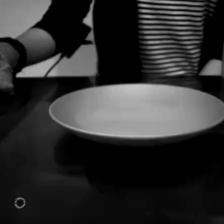

In [90]:
display.plot_tensor(views[0][1])

In [91]:
def score_seqs(pred,targ):
    disance = levenshtein(pred,targ)
    return 1 - ((disance)/len(pred))

def levenshtein(a,b):
    "Calculates the Levenshtein distance between a and b."
    a = a.cpu().data.numpy()
    b = b.cpu().numpy()
    n, m = len(a), len(b)
    if n > m:
        # Make sure n <= m, to use O(min(n,m)) space
        a,b = b,a
        n,m = m,n
        
    current = range(n+1)
    for i in range(1,m+1):
        previous, current = current, [i]+[0]*n
        for j in range(1,n+1):
            add, delete = previous[j]+1, current[j-1]+1
            change = previous[j-1]
            if a[j-1] != b[i-1]:
                change = change + 1
            current[j] = min(add, delete, change)
            
    return current[n]

In [93]:
metrics = {"acc":{}, "greedy":{}, "beam":{}}
for key in metrics: 
    results = {}
    for i in range(25):
        results[i] =  []
    metrics[key] = results
    
encoder.eval()
decoder.eval()
beam = Beam(decoder.lstm, decoder.embed, decoder.linear, 5, vocab, 0.7)
for i, (images, captions, lengths, objs) in enumerate(dataloaders['test']):
    # Set mini-batch dataset
    images = varify(images, volatile=True)
    ###
    images = [view[:,1,...].unsqueeze(1) for view in images]
    ###
    features = encoder(images)
    print(i)
    
    #batch
    for i in range(features.shape[0]):
        target = captions[i]
        tot = lengths[i]
        
        sample_id = decoder.sample(features[i].unsqueeze(0)).cpu().data.numpy()
        corr = 0
        for j in range(tot):
            if sample_id[j] == target[j]:
                corr += 1
        t_acc = corr/tot
        
        #print("Target: ", target.cpu().numpy()[:tot])
        #print("Fixed sample:" , sample_id[:tot])
        #print("Acc: ", t_acc)
        metrics['acc'][objs[i]].append(t_acc)
        
        
        g = decoder.my_sample(features[i].unsqueeze(0))
        g_distance = score_seqs(g,target[:tot])
        metrics['greedy'][objs[i]].append(g_distance)
        #print("Greedy sample:",g.data.cpu().numpy())
        #print("Greedy: ",g_distance)
        
        beam.start_beams(features[i])
        beam.sample_beams()
        b,_ = beam.get_best()
        b_distance = score_seqs(b,target[:tot])
        metrics['beam'][objs[i]].append(b_distance)
        #print("Beam sample:",b.data.cpu().numpy().T[0])
        #print("Beam: ",b_distance)
        #print()
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [94]:
for key in metrics:
    results = metrics[key]
    all_res = []
    for item,val in results.items():
        all_res += val
    print("{:7} {:.2f}".format(key,np.array(all_res).mean()))

acc     0.36
greedy  0.50
beam    0.49


In [42]:
obj_to_ix['key']

16

In [43]:
for key in metrics:
    results = metrics[key]
    all_res = []
    cats = []
    for cat, objs in obj_categories.items():
        cat_acc = []
        for obj in objs:
            cat_acc += results[obj_to_ix[obj]]
        cats.append((np.array(cat_acc).mean(),cat))
        cats = sorted(cats)
    for acc,cat in cats:
        print("{:6} & {:.2f} \\\\".format(cat,acc))
        
    print("-------------")
    items = []
    for item,val in results.items():
        items.append((np.array(val).mean(),ix_to_obj[item]))
        all_res += val
        
    items = sorted(items)
    for acc, item in items:
        print("{:6} & {:.2f} & {:12} \\\\".format(obj_to_cat[item],acc,item))
        
    print("-------------")
    
    print("{:6} & {:.2f}".format(key,np.array(all_res).mean()))
    
    print("#############")
    print()

flat   & 0.20 \\
big    & 0.28 \\
long   & 0.35 \\
small  & 0.36 \\
tall   & 0.44 \\
-------------
flat   & 0.15 & cd           \\
flat   & 0.16 & key          \\
flat   & 0.17 & button       \\
flat   & 0.21 & game_card    \\
long   & 0.24 & cigarette    \\
flat   & 0.25 & credit_card  \\
big    & 0.25 & coffee_mug   \\
big    & 0.26 & plate        \\
flat   & 0.27 & comb         \\
big    & 0.29 & book         \\
long   & 0.33 & marker       \\
big    & 0.33 & bowl         \\
small  & 0.33 & match        \\
small  & 0.34 & shell        \\
small  & 0.35 & screw        \\
long   & 0.36 & screw_driver \\
small  & 0.37 & french_chalk \\
tall   & 0.37 & toy          \\
small  & 0.40 & rubber_band  \\
tall   & 0.43 & chestnut     \\
tall   & 0.44 & matchbox     \\
tall   & 0.45 & tape         \\
tall   & 0.46 & glasses      \\
long   & 0.48 & shashlik     \\
tall   & 0.48 & salt_shaker  \\
-------------
acc    & 0.33
#############

big    & 0.34 \\
flat   & 0.45 \\
tall   & 0.48 \\
long   

In [21]:
def plain_levenshtein(a,b):
    "Calculates the Levenshtein distance between a and b."
    n, m = len(a), len(b)
    if n > m:
        # Make sure n <= m, to use O(min(n,m)) space
        a,b = b,a
        n,m = m,n
        
    current = range(n+1)
    for i in range(1,m+1):
        previous, current = current, [i]+[0]*n
        for j in range(1,n+1):
            add, delete = previous[j]+1, current[j-1]+1
            change = previous[j-1]
            if a[j-1] != b[i-1]:
                change = change + 1
            current[j] = min(add, delete, change)
            
    return current[n]

def score_markov(pred,targ):
    distance = plain_levenshtein(pred,targ)
    return 1 - ((distance + 1)/len(pred))

In [22]:
def get_category(dataloader,category):
    seqs = []
    objs_in_category = obj_categories[category]
    #print(objs_in_category)
    for i, (images, captions, lengths, objs) in enumerate(dataloader):
        print("\r{}/{}".format(i,len(dataloader)),end="")
        for caption, length, obj in zip(captions,lengths, objs):
            if ix_to_obj[obj] in objs_in_category:
                seqs.append(caption[:length].cpu().numpy())
    return seqs

In [11]:
#a = get_category(dataloaders['test'],'flat')

['key', 'button', 'cd', 'credit_card', 'game_card', 'comb']
80/81

In [23]:
def vectorize(tag,vocab):
    state = np.zeros(len(vocab))
    state[tag] += 1
    return state

def sample(distr,vocab):
    return np.random.choice(len(vocab),p=distr)

In [24]:
from sklearn.preprocessing import normalize

def test_category(category,training_loader, test_loader):
    markov = np.zeros((len(vocab),len(vocab)))
    starts = np.zeros((len(vocab)))
    print("Computing Markov for {}".format(category))
    training_samples = get_category(training_loader,category)
    for seq in training_samples:
        #seq = generate_label(category)
        #seq.append(vocab.stop)
        starts[seq[0]] += 1
        for i,j in zip(seq,seq[1:]):
            markov[i][j] += 1
    print()
    print("Normalizing Markov for {}".format(category))
    starts /= starts.sum()
    markov = normalize(markov,axis=1,norm='l1')

    test_trials = get_category(test_loader,category)
    acc = []
    print()
    print("Testing Markov for {}".format(category))
    lev = []
    for target_seq in test_trials:
        generated_sequence = []
        curr_tag = sample(starts,vocab)
        curr_state = vectorize(curr_tag,vocab)
        correct = 0
        tot = len(target_seq)
        generated_sequence.append(curr_tag)
        for tag in target_seq:
            if(curr_tag == tag):
                correct += 1
            curr_state = curr_state.dot(markov)
            curr_state /= curr_state.sum()
            curr_tag = sample(curr_state,vocab)
            generated_sequence.append(curr_tag)
        acc.append(correct/tot)
        
        lev.append(score_markov(generated_sequence,target_seq))
    
    tag_acc = np.array(acc).mean()
    lev_acc = np.array(lev).mean()
    print("Test {}: Acc {:.2f} - Lev {:.2f}".format(category, tag_acc, lev_acc))
    print("-------------------------------")

In [25]:
for cat in obj_categories:
    test_category(cat,dataloaders['train'], dataloaders['test'])

Computing Markov for flat
376/377
Normalizing Markov for flat
80/81
Testing Markov for flat
Test flat: Acc 0.21 - Lev 0.17
-------------------------------
Computing Markov for tall
376/377
Normalizing Markov for tall
80/81
Testing Markov for tall
Test tall: Acc 0.25 - Lev 0.18
-------------------------------
Computing Markov for big
376/377
Normalizing Markov for big
80/81
Testing Markov for big
Test big: Acc 0.18 - Lev 0.16
-------------------------------
Computing Markov for long
376/377
Normalizing Markov for long
80/81
Testing Markov for long
Test long: Acc 0.30 - Lev 0.26
-------------------------------
Computing Markov for small
376/377
Normalizing Markov for small
80/81
Testing Markov for small
Test small: Acc 0.28 - Lev 0.29
-------------------------------


In [26]:
(0.17 + 0.18 + 0.16 + 0.26 + 0.29)/5

0.21200000000000002

In [95]:
(0.46 + 0.48 + 0.43 + 0.57 + 0.58)/5

0.504

In [98]:
(0.45 + 0.48 + 0.39 + 0.56 + 0.54)/5

0.484